## Evaulating classifier performance. 

To run this script please first run 'fitting_classifiers.ipynb' to train optimised SVC, LR, RF. This script uses those pre-trained joblib models.

In [1]:
DATA_DIR = "../data/"   
DATA = "CAP"
CLASS_LABEL = 'pca_death_code'  # Target label to predict

RANDOM_STATE = 42
TEST_SIZE = 0.2

CV = 5

In [2]:
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from helper import (pd_print, 
                    accuracy,
                    lemmatize_text,
                    summarise_gridsearch_classifier,
                    calibrate_random_forest, 
                    plot_calibration_curve,
                    plot_calibration_curve_easy_hard,
                    plot_roc_curve,
                    compute_all_metrics)

from cap_helper import *

In [3]:
print("Loading CAP prostate cancer data for preprocessing.")
df = load_data(DATA_DIR)
# Combine text from all feature columns into a single string column
df = concatenate_feature_columns(df)
# Link to dates of death:
df = add_dates(df, DATA_DIR)
# Link to reviewer Ids:
df = add_reviewer_ids(df, DATA_DIR)
# Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
df = convert_dates_relative(df)  

print("Preprocessing complete.")

Loading CAP prostate cancer data for preprocessing.
Preprocessing complete.


In [4]:
stemmer = WordNetLemmatizer()
X,y = df.combined, df[CLASS_LABEL]
documents = lemmatize_text(X, stemmer)
X_train, X_test, y_train, y_test = train_test_split(documents, 
                                                    df[CLASS_LABEL], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train = np.array(X_train)
y_train = np.array(y_train)

We extract the same folds that were used in the GridsearchCV optimisation the classifiers (see fitting_classifiers.ipynb), to compute the validation performance for each fold:

In [ ]:
X_dict = {'test': X_test}
y_dict = {'test': y_test}
names = ['test']

skf = StratifiedKFold(n_splits=CV, random_state=RANDOM_STATE);

x_fold_i = {}
y_fold_i = {}
i = 1

for train_index, validation_index in skf.split(X_train, y_train):
    
    X_dict['fold_%s' % i] = X_train[validation_index]
    y_dict['fold_%s' % i] = y_train[validation_index]
    names.append('fold_%s' % i)
    i += 1

In [6]:
clf = {}
performance = {}

for classifier in ['svc', 'lr', 'rf']:

    CLASSIFIER_FILENAME = 'cap_%s_gridsearch.joblib' % classifier
    clf[classifier] = load('models/' + CLASSIFIER_FILENAME)
    
    performance[classifier] = compute_all_metrics(
        clf[classifier], X_dict, y_dict, names
    )

In [7]:
summary_table = pd.DataFrame()
summary_table['classifier'] = performance.keys()

In [8]:
from sklearn.metrics import (brier_score_loss, precision_score, 
                             recall_score, f1_score, confusion_matrix)

In [9]:
for metric in performance['svc'].metric:
    summary_table[metric] = [float(performance[key].loc[performance[key].metric==metric].test) for key in performance.keys()]

In [10]:
summary_table

,classifier,AUC,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,FP/FN ratio
0,svc,0.974893,91.570881,0.937908,0.919872,0.928803,0.919872,0.909524,0.760000
1,lr,0.973275,90.229885,0.919614,0.916667,0.918138,0.916667,0.880952,0.961538
2,rf,0.973107,91.762452,0.932476,0.929487,0.930979,0.929487,0.900000,0.954545


#### We now produce the ROC curve for the random forest for each training fold and the test set:

In [11]:
CLASSIFIER_FILENAME = 'cap_rf_gridsearch.joblib' 

clf_dict = {
    name: load('models/' + CLASSIFIER_FILENAME) 
    for name in names
}

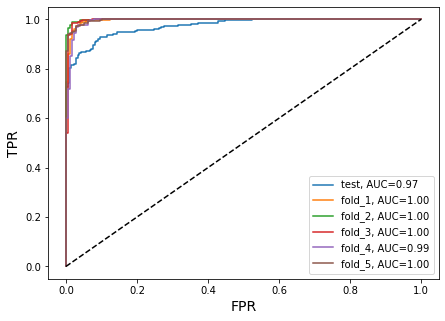

In [12]:
plot_roc_curve(clf_dict, X_dict, y_dict, names, save_name='roc_5folds.jpg')

#### We now produce and ROC curve for the three classifiers to compare performance on the training set:

In [13]:
names = ['svc', 'lr', 'rf']

X_dict = {}
y_dict = {}

for name in names:
    X_dict[name] = X_test
    y_dict[name] = y_test

clf_dict = {
    name: load('models/cap_%s_gridsearch.joblib' % name) 
    for name in names
}

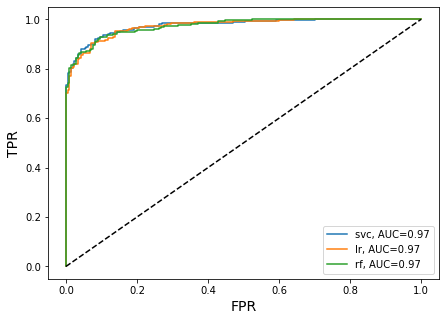

In [14]:
plot_roc_curve(clf_dict, X_dict, y_dict, names, save_name='roc_3clf.jpg')

#### We now compare the word frequencies in our test and training set. And compare these with a benchmark datset from this domain (CHEMPROT https://pubmed.ncbi.nlm.nih.gov/20935044/).

In [39]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

In [15]:
chemprot = pd.read_csv(
    DATA_DIR + '/ChemProt_Corpus/chemprot_training/chemprot_training/chemprot_training_abstracts.tsv',
    delimiter='\t',
    names=['id', 'title', 'abstract']
)       
chemprot_lemmatized = lemmatize_text(chemprot.abstract, stemmer)
len(chemprot_lemmatized)

1020

In [16]:
def get_word_freqs(document):
    freqs = pd.DataFrame.from_dict(Counter(' '.join(document).split()), 
                                         orient='index',
                                         columns=['counts'])

    freqs['freq'] = freqs.counts / sum(freqs.counts)
    freqs.sort_values('freq', ascending=False, inplace=True)
    return freqs

In [17]:
chemprot_counts = get_word_freqs(chemprot_lemmatized)
chemprot_counts.head()

,counts,freq
the,10979,0.048768
of,9558,0.042456
and,8104,0.035998
in,6760,0.030028
to,3757,0.016688


In [18]:
x_train_counts = get_word_freqs(X_train)
x_test_counts = get_word_freqs(X_test)

In [30]:
print(len(set(x_test_counts.index).intersection(x_train_counts.index)))
print(len(x_test_counts.index))
print(len(x_train_counts.index))

6079
7439
13123


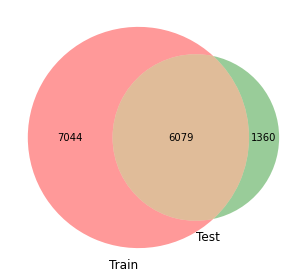

In [42]:
venn2(subsets=[
    len(set(x_train_counts.index).difference(x_test_counts.index)),
    len(set(x_test_counts.index).difference(x_train_counts.index)),
    len(set(x_test_counts.index).intersection(x_train_counts.index))],
    set_labels=('Train', 'Test')  
);
plt.tight_layout()
plt.savefig('venn_train_test.jpg', dpi=300)

In [20]:
print(len(set(chemprot_counts.index).intersection(x_train_counts.index)))
print(len(chemprot_counts.index))
print(len(x_train_counts.index))

4655
15623
13123


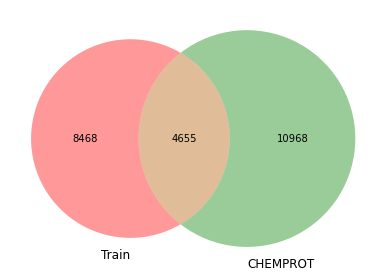

In [45]:
venn2(subsets=[
    len(set(x_train_counts.index).difference(chemprot_counts.index)),
    len(set(chemprot_counts.index).difference(x_train_counts.index)),
    len(set(chemprot_counts.index).intersection(x_train_counts.index))],
    set_labels=('Train', 'CHEMPROT')  
);
plt.tight_layout()
plt.savefig('venn_train_chemprot.jpg', dpi=300)

In [22]:
x_test_counts.loc[set(x_test_counts.index).difference(x_train_counts.index)].sort_values('freq', ascending=False)

,counts,freq
metastic,4,0.000023
myasthenia,4,0.000023
downstairs,4,0.000023
cytarabine,4,0.000023
assault,3,0.000017
...,...,...
msec,1,0.000006
hugely,1,0.000006
gencitabine,1,0.000006
upto,1,0.000006
